In [14]:
# Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import glob
from scipy import ndimage
from scipy import signal
import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float

from bisect import bisect_left
import math


In [15]:
# Utility functions

#BASIC CROP FRAME
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.92


# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

# returns a logical matrix of values beyond a threshld
def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

# initial static crop and a seondary dynamic crop based on signal2noise ratio
def crop_full_scan(image):
    temp = crop(image, Y_START, Y_END, X_START, X_END)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=BG_2_OBJ_RATIO)
    temp = crop(image, Y_START+ymin, Y_START+ymax, X_START+xmin, X_START+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/sliced/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    return crop_full_scan(image)

# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

def calc_neighbors(slice_map, col, row):
#     import pdb; pdb.set_trace()
    if ((col-1, row) in slice_map and slice_map[(col-1, row)] != None):
        slice_map[(col, row)]["left"] = slice_map[(col-1, row)]
        slice_map[(col-1, row)]["right"] = slice_map[(col, row)]
    if ((col+1, row) in slice_map and slice_map[(col+1, row)] != None):
        slice_map[(col, row)]["right"] = slice_map[(col+1, row)]
        slice_map[(col+1, row)]["left"] = slice_map[(col, row)]
    if ((col, row-1) in slice_map and slice_map[(col, row-1)] != None):
        slice_map[(col, row)]["top"] = slice_map[(col, row-1)]
        slice_map[(col, row-1)]["bottom"] = slice_map[(col, row)]
    if ((col, row+1) in slice_map and slice_map[(col, row+1)] != None):
        slice_map[(col, row)]["bottom"] = slice_map[(col, row+1)]
        slice_map[(col, row+1)]["top"] = slice_map[(col, row)]
    

def slice_to_static_slices(cropped_original):
    structure = {}
    x, y = cropped_original.shape
    n = 0
    while ((n + 1) * 250 < x):
        m = 0
        while ((m + 1) * 250 < y):
            cube = (crop(cropped_original, m * 250, (m + 1) * 250, n * 250, (n + 1) * 250))
            if np.median(cube) > 50:
                structure[(n, m)] = {}
                structure[(n, m)]["cube"] = cube
                calc_neighbors(structure, n, m)
            else:
                structure[(n, m)] = None
            m += 1
        n += 1
    return structure, m, n

In [16]:
# Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    


/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


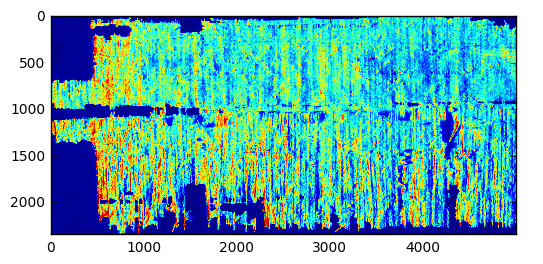

In [17]:
# Read the blue wave-length image and show it
blue = read_and_crop("PX303-Fg001-V-C01-R01-D05032015-T112722-MLIR__026.jpg")

# Show the relevant image
plt.imshow(blue)

cubes, cols, rows = slice_to_static_slices(blue)

(19, 9)

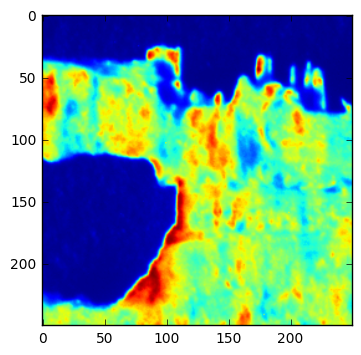

In [18]:
# len(res)
plt.imshow(res[(3,0)]["cube"])
# np.median(res[(3,0)])
cols, rows

# TODO:
# 1/ ignore semi-dark cubes? or let them be...
# save a struct for each cube with the meta data of neighbors
# run the fingerprint algorithm for each cube and attach to meta data struct
# run a training algorithm aimed at minimizing the errors of identifying the neighbors
# might need to run first horizontal and then vertical
